Training ODE2 model...
Epoch 0: Loss = 1.3777776956558228
Epoch 1000: Loss = 0.2158345878124237
Epoch 2000: Loss = 0.0023584545124322176
Epoch 3000: Loss = 0.00047083362005650997
Epoch 4000: Loss = 0.0002753275039140135
Training ODE1 model...
Epoch 0: Loss = 1.9547926187515259
Epoch 1000: Loss = 0.15226635336875916
Epoch 2000: Loss = 0.04261549934744835
Epoch 3000: Loss = 0.004089591559022665
Epoch 4000: Loss = 0.0049013965763151646
Training ODE1 alternative model...
Epoch 0: Loss = 1.220625638961792
Epoch 1000: Loss = 0.2678593099117279
Epoch 2000: Loss = 0.16981978714466095
Epoch 3000: Loss = 0.12036697566509247
Epoch 4000: Loss = 0.0889538899064064


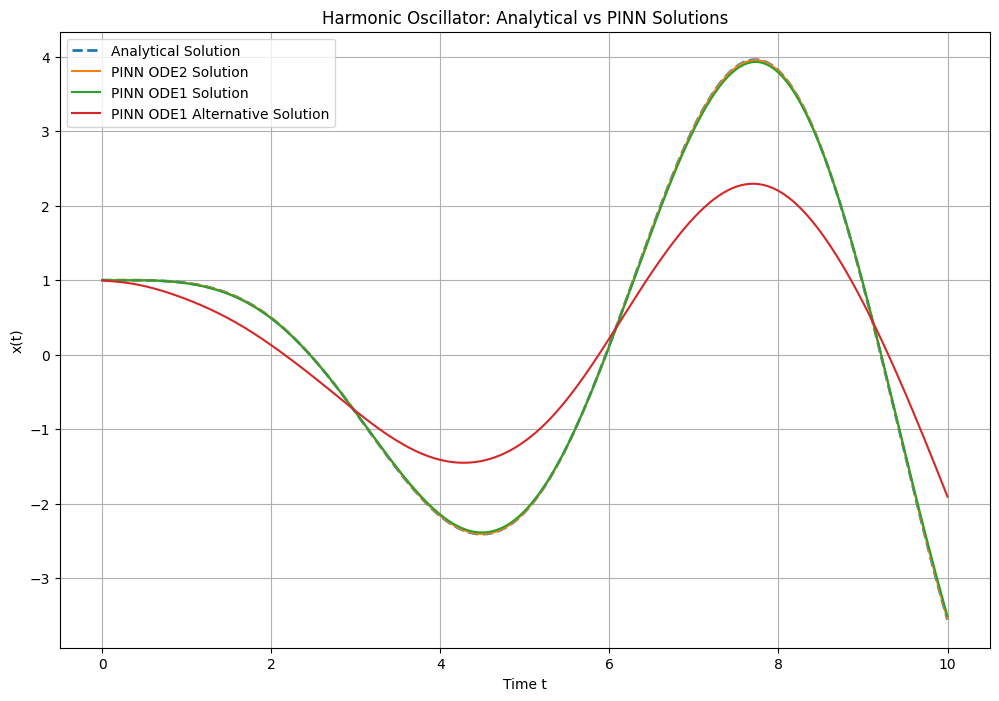

In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the harmonic oscillator parameters
omega0 = 1.0  # Natural frequency
omega = 1.0   # Forcing frequency
x0 = 1.0      # Initial position
v0 = 0.0      # Initial velocity
t_max = 10.0  # Maximum time
num_points = 500  # Number of time points

# Generate time points
t = torch.linspace(0, t_max, num_points, requires_grad=True).view(-1, 1)

# Define the neural network for ODE2 (one output: x)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: x
        )

    def forward(self, t):
        return self.net(t)

# Define the neural network for ODE1 systems (two outputs: x and y)
class PINNSystem(nn.Module):
    def __init__(self):
        super(PINNSystem, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)  # Outputs: x and y
        )

    def forward(self, t):
        return self.net(t)

# Define the analytical solution for the second-order ODE
def analytical_solution(t, omega0, omega, x0, v0):
    # Homogeneous solution
    C1 = x0
    C2 = v0 / omega0
    homogeneous = C1 * np.cos(omega0 * t) + C2 * np.sin(omega0 * t)

    # Particular solution
    if omega != omega0:
        particular = (1 / (omega0**2 - omega**2)) * np.cos(omega * t)
    else:
        particular = 0.5 * t * np.sin(omega0 * t)  # Resonance case

    return homogeneous + particular

# Loss function for ODE2
def loss_ode2(model, t):
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    residual = d2x_dt2 + omega0**2 * x - torch.cos(omega * t)
    ic_loss = (x[0] - x0)**2 + (dx_dt[0] - v0)**2
    return torch.mean(residual**2) + ic_loss

# Loss function for ODE1
def loss_ode1(model, t):
    x, y = model(t).split(1, dim=1)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    residual_x = dx_dt - y
    residual_y = dy_dt + omega0**2 * x - torch.cos(omega * t)
    ic_loss = (x[0] - x0)**2 + (y[0] - v0)**2
    return torch.mean(residual_x**2) + torch.mean(residual_y**2) + ic_loss

# Loss function for alternative ODE1
def loss_ode1_alt(model, t):
    x, y = model(t).split(1, dim=1)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    residual_x = dx_dt - omega * y - torch.sin(omega * t) / omega
    residual_y = dy_dt + omega * x
    ic_loss = (x[0] - x0)**2 + (y[0] - v0 / omega)**2
    return torch.mean(residual_x**2) + torch.mean(residual_y**2) + ic_loss

# Training function
def train_model(model, loss_fn, t, num_epochs=5000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return model

# Train ODE2 model
model_ode2 = PINN()
print("Training ODE2 model...")
model_ode2 = train_model(model_ode2, loss_ode2, t)

# Train ODE1 model
model_ode1 = PINNSystem()
print("Training ODE1 model...")
model_ode1 = train_model(model_ode1, loss_ode1, t)

# Train ODE1 alternative model
model_ode1_alt = PINNSystem()
print("Training ODE1 alternative model...")
model_ode1_alt = train_model(model_ode1_alt, loss_ode1_alt, t)

# Evaluate and plot results
t_np = t.detach().numpy()
x_analytical = analytical_solution(t_np, omega0, omega, x0, v0)
x_ode2 = model_ode2(t).detach().numpy()
x_ode1 = model_ode1(t).detach().numpy()[:, 0]
x_ode1_alt = model_ode1_alt(t).detach().numpy()[:, 0]

plt.figure(figsize=(12, 8))
plt.plot(t_np, x_analytical, label="Analytical Solution", linestyle='--', linewidth=2)
plt.plot(t_np, x_ode2, label="PINN ODE2 Solution")
plt.plot(t_np, x_ode1, label="PINN ODE1 Solution")
plt.plot(t_np, x_ode1_alt, label="PINN ODE1 Alternative Solution")
plt.legend()
plt.xlabel("Time t")
plt.ylabel("x(t)")
plt.title("Harmonic Oscillator: Analytical vs PINN Solutions")
plt.grid(True)
plt.show()
